## Подключаем необходимые модули

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.11.0
GPU is ON


## Подготовим набор данных для обучения

In [ ]:
CLASSES = 12

SAMPLE_SIZE = (256, 256)

OUTPUT_SIZE = (1024, 398)

In [ ]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    masks = []
    
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))
    
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks #masks

def augmentate_images(image, masks):   
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)
    
    return image, masks

In [ ]:
images = sorted(glob.glob('/content/drive/MyDrive/ВКР Карпов /CMP_facade_DB_base/base2/base/*.jpg'))
masks = sorted(glob.glob('/content/drive/MyDrive/ВКР Карпов /CMP_facade_DB_base/base2/base/*.png'))

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))
dataset = dataset.repeat(5)
dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
num_elements = tf.data.experimental.cardinality(dataset).numpy()
num_elements

1890

## Разделим набор данных на обучающий и проверочный

In [ ]:
train_dataset = dataset.take(1500).cache()
test_dataset = dataset.skip(1500).take(100).cache()
 
train_dataset = train_dataset.batch(16)
test_dataset = test_dataset.batch(16)

## Обозначим основные блоки модели

In [ ]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

## Построим U-NET подобную архитектуру

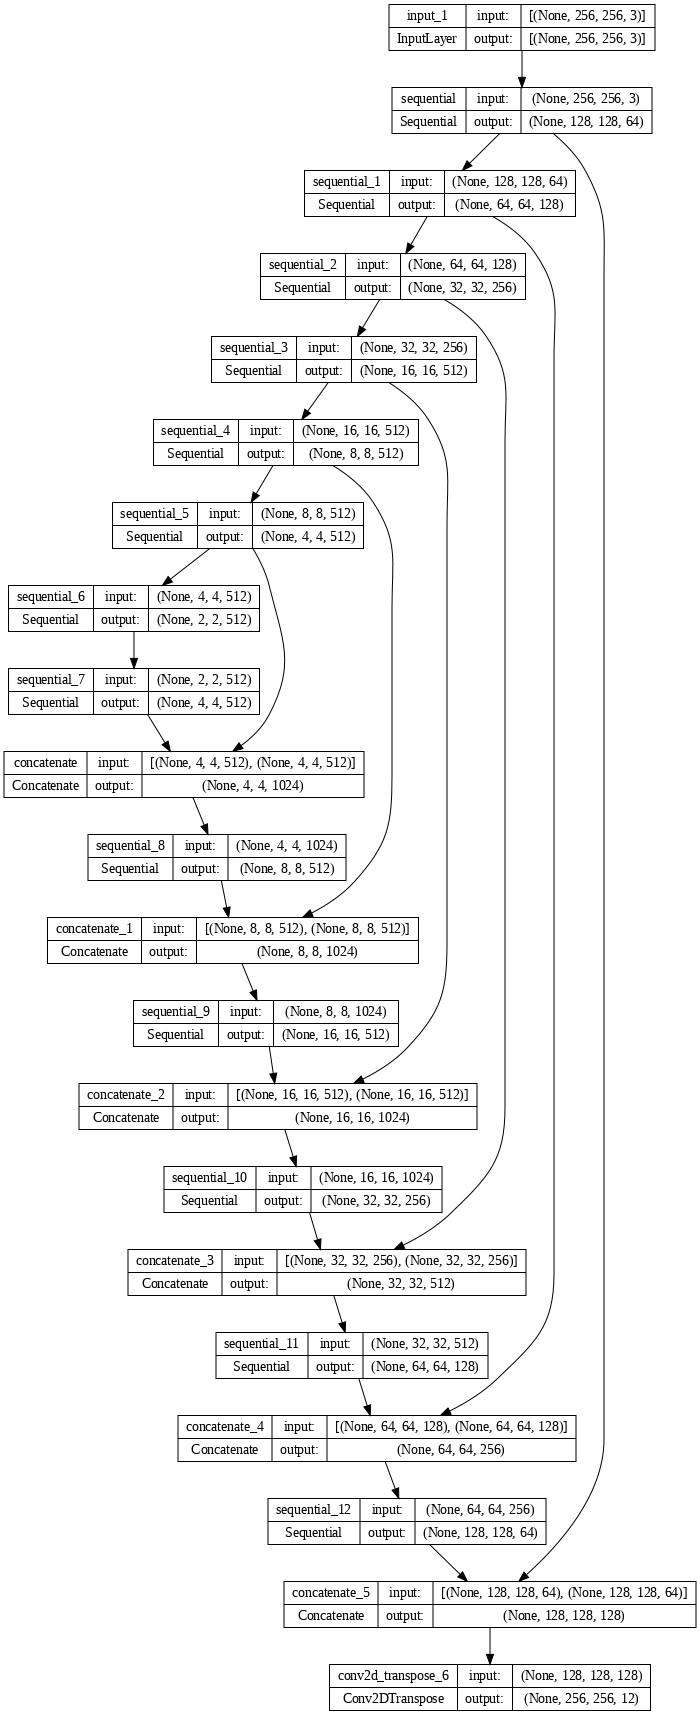

In [ ]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
    
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

## Определим метрики и функции потерь

In [ ]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)
    
    dice_summ = 0
    
    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
        
    avg_dice = dice_summ / CLASSES
    
    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

In [ ]:
def iou_metric(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, [1, 2, 3]) + tf.reduce_sum(y_pred, [1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_loss(y_true, y_pred):
    return 1 - iou_metric(y_true, y_pred)


## Компилируем модель

In [ ]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

## Обучаем нейронную сеть и сохраняем результат

In [ ]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=14, initial_epoch=0)



Epoch 1/14
94/94 [==============================] - 224s 2s/step - loss: 0.3582 - dice_mc_metric: 6.4111e-04 - val_loss: 0.3077 - val_dice_mc_metric: 1.8211e-04
Epoch 2/14
94/94 [==============================] - 30s 314ms/step - loss: 0.2664 - dice_mc_metric: 0.1152 - val_loss: 0.2987 - val_dice_mc_metric: 0.0057
Epoch 3/14
94/94 [==============================] - 30s 320ms/step - loss: 3.2485e-04 - dice_mc_metric: 0.9989 - val_loss: 0.0016 - val_dice_mc_metric: 0.9952
Epoch 4/14
94/94 [==============================] - 30s 324ms/step - loss: 1.1017e-05 - dice_mc_metric: 1.0000 - val_loss: 2.0048e-05 - val_dice_mc_metric: 0.9999
Epoch 5/14
94/94 [==============================] - 31s 329ms/step - loss: 9.1302e-06 - dice_mc_metric: 1.0000 - val_loss: 3.7179e-06 - val_dice_mc_metric: 1.0000
Epoch 6/14
94/94 [==============================] - 32s 343ms/step - loss: 8.0024e-06 - dice_mc_metric: 1.0000 - val_loss: 1.7259e-06 - val_dice_mc_metric: 1.0000
Epoch 7/14
94/94 [==================

In [ ]:
unet_like.save_weights('/content/drive/MyDrive/Моделька CV')

## Загрузим модель

In [ ]:
unet_like.load_weights('/content/drive/MyDrive/Моделька CV')

In [ ]:
i = 68

filename = images[i]
frame = imread(filename)
sample = resize(frame, SAMPLE_SIZE)

predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))

real_mask = masks[i]
real_mask = imread(real_mask)
real_mask = resize(real_mask, SAMPLE_SIZE)

1/1 [==============================] - 1s 563ms/step


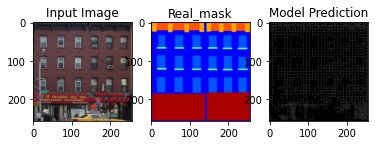

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(sample)
ax[0].set_title('Input Image')
ax[1].imshow(real_mask)
ax[1].set_title('Real_mask')

arr = predict.argmax(axis=-1)
arr[arr != 11] = 0

ax[2].imshow(arr, cmap = 'gray')
ax[2].set_title('Model Prediction')
plt.show()

In [ ]:
def count_windows(mask, window_size=55):
    visited = np.zeros_like(mask)
    count = 0

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j] == 1 and visited[i, j] == 0:
                stack = [(i, j)]
                visited[i, j] = 1
                group_size = 1

                while stack:
                    x, y = stack.pop()
                    for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                        if (0 <= x+dx < mask.shape[0] and 0 <= y+dy < mask.shape[1] and
                                mask[x+dx, y+dy] == 1 and visited[x+dx, y+dy] == 0):
                            stack.append((x+dx, y+dy))
                            visited[x+dx, y+dy] = 1
                            group_size += 1

                if group_size >= window_size:
                    count += 1

    return count


In [ ]:
count_windows(prediction.argmax(axis=-1))

# Optional (Попробуем убрать все классы кроме окон и обучить модель на 2 классах)

In [ ]:
color_BGR = {'background': (170, 0, 0),
'facade': (255, 0 ,0),
'window':(255, 85, 0),
'door': (255, 170, 0),
'cornice': (170, 255, 85),
'sill': (0, 170, 255),
'balcony': (85, 255, 170),
'blind': (0, 255, 255),
'deco': (255, 255, 0),
'molding': (0, 85, 255),
'pillar': (0, 0, 255),
'shop': (0, 0, 170)}

In [ ]:

color_RGB = {k: tuple(reversed(v)) for k, v in color_BGR.items()}
color_RGB

{'background': (0, 0, 170),
 'facade': (0, 0, 255),
 'window': (0, 85, 255),
 'door': (0, 170, 255),
 'cornice': (85, 255, 170),
 'sill': (255, 170, 0),
 'balcony': (170, 255, 85),
 'blind': (255, 255, 0),
 'deco': (0, 255, 255),
 'molding': (255, 85, 0),
 'pillar': (255, 0, 0),
 'shop': (170, 0, 0)}

In [ ]:
color_RGB.values()

dict_values([(0, 0, 170), (0, 0, 255), (0, 85, 255), (0, 170, 255), (85, 255, 170), (255, 170, 0), (170, 255, 85), (255, 255, 0), (0, 255, 255), (255, 85, 0), (255, 0, 0), (170, 0, 0)])

In [ ]:
from PIL import Image
for mask in masks:
  # Открываем изображение
  img = Image.open(mask)
  img = img.convert("RGB")

  for x in range(img.width):
      for y in range(img.height):
          pixel = img.getpixel((x,y))
          if pixel == (255, 255, 0):
            img.putpixel((x,y), (0, 85, 255))

          if pixel == (0, 85, 255):
            pass

          if pixel in [(0, 0, 255), (0, 170, 255), (85, 255, 170), (255, 170, 0), (170, 255, 85), (0, 255, 255), (255, 85, 0), (255, 0, 0), (170, 0, 0)]: 
              img.putpixel((x,y), (0, 0, 170))

  img.save(mask)